In [1]:
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

from earthquakes.data.data import EarthquakeData
from earthquakes.settings import read_coordinates

cwd = Path.home() / "earthquakes"
load_dotenv(cwd / ".env")

raw_data = pd.read_csv(cwd / "csv/9923ce9a42736848b544e335a4d7c5fb.csv")
(minlat, maxlat), (minlong, maxlong) = read_coordinates()
qdata = EarthquakeData(
    raw_data,
    features=["depth", "mag"],
    targets=["mag"],
    zero_columns=["depth", "mag"],
    time_column=True,
    delta_time=True,
    drop_time_column=True,
    min_latitude=minlat,
    min_longitude=minlong,
    min_magnitude=0,
    max_magnitude=7,
)
# hacer una grafica de distribucion de numero de eventos por magnitud
# hacer una grafica de distribucion de numero de eventos por bines
# cambiar el tamaño de los bines
qdata.data

,depth,mag,delta
0,162.000,4.9,0
1,33.000,5.0,2039958
2,33.000,4.5,561
3,157.000,4.0,421577
4,161.000,4.6,918302
...,...,...,...
3979,12.009,4.4,151590
3980,50.621,4.3,1396031
3981,10.000,4.5,67987
3982,10.000,4.7,13967


In [2]:
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split

# # Sample data
# data = qdata.data

# for f in qdata.features:
#     data[f"{f}_binned"] = pd.cut(data[f], bins=3, labels=[0, 1, 2])

# data = pd.get_dummies(data, columns=[f"{f}_binned" for f in qdata.features], prefix=qdata.features)
# for col in data.columns:
#     if "_" in col:
#         data[col] = data[col].astype(int)

# X = qdata.normalize(data)
# features = list(X.columns)
# y = pd.cut(data["mag"], bins=3, labels=[0, 1, 2])
# X, y

In [3]:
# X = X.iloc[:-1, :]
# y = y.iloc[1:]

# # Display the resulting DataFrame
# print(X, X.shape)
# print(y, y.shape)

# # # Split with stratification
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# print("Training labels distribution:\n", y_train.value_counts())
# print("Testing labels distribution:\n", y_test.value_counts())

In [4]:
data, _ = qdata.cut(qdata.data, quantiles=5)
one_hot = qdata.one_hot(data)
one_hot_features = list(one_hot.columns) #+ list(qdata.features)
print(one_hot_features)
one_hot[["target"]] = data[["mag_binned"]]
one_hot = pd.concat([one_hot, qdata.normalized_data], axis=1)
one_hot

['depth_0', 'depth_1', 'depth_2', 'depth_3', 'depth_4', 'mag_0', 'mag_1', 'mag_2', 'mag_3', 'mag_4', 'delta_0', 'delta_1', 'delta_2', 'delta_3', 'delta_4']


,depth_0,depth_1,depth_2,depth_3,depth_4,mag_0,mag_1,mag_2,mag_3,mag_4,...,delta_2,delta_3,delta_4,target,depth,mag,delta,depth_binned,mag_binned,delta_binned
0,0,0,0,1,0,0,0,0,0,1,...,0,0,0,4,0.989238,1.344806,-0.828422,3,4,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,1,4,-0.998882,1.606732,3.490287,0,4,4
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,2,-0.998882,0.297100,-0.827235,0,2,0
3,0,0,0,1,0,1,0,0,0,0,...,0,1,0,0,0.912179,-1.012533,0.064081,3,0,3
4,0,0,0,1,0,0,0,0,1,0,...,0,0,1,3,0.973826,0.559026,1.115676,3,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3979,1,0,0,0,0,0,0,1,0,0,...,0,0,0,2,-1.322391,0.035173,-0.507498,0,2,1
3980,0,1,0,0,0,0,1,0,0,0,...,0,0,1,1,-0.727311,-0.226753,2.127056,1,1,4
3981,1,0,0,0,0,0,0,1,0,0,...,0,0,0,2,-1.353354,0.297100,-0.684490,0,2,1
3982,1,0,0,0,0,0,0,0,1,0,...,0,0,0,3,-1.353354,0.820953,-0.798853,0,3,0


In [5]:
# X.loc[:,"target"] = y
lookback = 50
sequences,targets = qdata.to_sequences(one_hot, lookback, features=one_hot_features, targets=["target"])
(X_train, y_train), (X_test, y_test) = qdata.split(sequences, targets[:,-1], test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

  0%|          | 0/3934 [00:00<?, ?it/s]

torch.Size([3147, 15, 50]) torch.Size([787, 15, 50]) torch.Size([3147, 1]) torch.Size([787, 1])


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)
# X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train.to(torch.long))
test_dataset = TensorDataset(X_test, y_test.to(torch.long))
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


# Define the model
# class SimpleNN(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(SimpleNN, self).__init__()
#         self.fc1 = nn.Linear(input_dim, 64)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, output_dim)

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = torch.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

# Define the model
class LSTMModel(nn.Module):
    def __init__(self, output_dim):
        super(LSTMModel, self).__init__()
        self.fc1 = nn.LSTM(50, 64, 2, batch_first=True)
        self.flatten = nn.Flatten()
        self.out = nn.LazyLinear(output_dim)

    def forward(self, x):
        x, _ = self.fc1(x)
        x = self.flatten(x)
        return self.out(x)

input_dim = X_train.shape[1]
output_dim = one_hot["target"].nunique()
model = LSTMModel(output_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        # print(outputs.shape, y_batch.shape)
        loss = criterion(outputs, y_batch.flatten())
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += y_batch.size(0)
        correct += (predicted == y_batch).sum().item()

print(f"Accuracy of the model on the test set: {100 * correct / total:.2f}%")

Epoch [1/100], Loss: 1.4748
Epoch [2/100], Loss: 1.5030
Epoch [3/100], Loss: 1.5137
Epoch [4/100], Loss: 1.4952
Epoch [5/100], Loss: 1.6532
Epoch [6/100], Loss: 1.5565
Epoch [7/100], Loss: 1.5969
Epoch [8/100], Loss: 1.5159
Epoch [9/100], Loss: 1.5374
Epoch [10/100], Loss: 1.5295
Epoch [11/100], Loss: 1.4592
Epoch [12/100], Loss: 1.3103
Epoch [13/100], Loss: 1.1094
Epoch [14/100], Loss: 0.8766
Epoch [15/100], Loss: 0.6336
Epoch [16/100], Loss: 0.4835
Epoch [17/100], Loss: 0.3906
Epoch [18/100], Loss: 0.2587
Epoch [19/100], Loss: 0.1158
Epoch [20/100], Loss: 0.0789
Epoch [21/100], Loss: 0.0405
Epoch [22/100], Loss: 0.0458
Epoch [23/100], Loss: 0.0623
Epoch [24/100], Loss: 0.0446
Epoch [25/100], Loss: 0.0476
Epoch [26/100], Loss: 0.0140
Epoch [27/100], Loss: 0.0280
Epoch [28/100], Loss: 0.0182
Epoch [29/100], Loss: 0.0639
Epoch [30/100], Loss: 0.0059
Epoch [31/100], Loss: 0.0080
Epoch [32/100], Loss: 0.0158
Epoch [33/100], Loss: 0.0046
Epoch [34/100], Loss: 0.0028
Epoch [35/100], Loss: 0

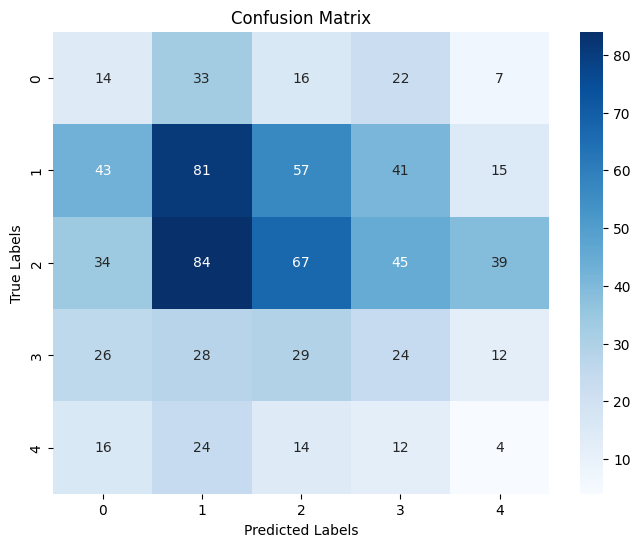

In [10]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
labels = list(range(output_dim))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

R1 (Recall) score for each class: [0.15217391 0.34177215 0.24907063 0.20168067 0.05714286]
[4 2 0 3 1]


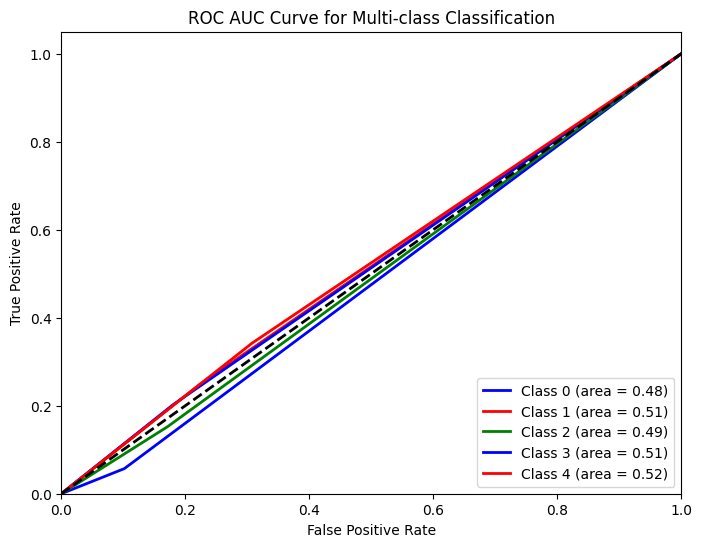

In [9]:
from sklearn.metrics import recall_score, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
import numpy as np

# R1 (Recall) Score
r1_score = recall_score(all_labels, all_preds, average=None)
print(f"R1 (Recall) score for each class: {r1_score}")

# Binarize the labels for ROC AUC curve (One-vs-Rest strategy)
all_labels_bin = label_binarize(all_labels, classes=labels)
all_preds_bin = label_binarize(all_preds, classes=labels)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(output_dim):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_preds_bin[:, i])
    roc_auc[i] = roc_auc_score(all_labels_bin[:, i], all_preds_bin[:, i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(output_dim), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve for Multi-class Classification')
plt.legend(loc="lower right")
plt.show()
